In [1]:
###Sara Vannah


# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.stats import norm
import math

import os, os.path

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

In [2]:
##This is from AxiCLASS
def is_number(s):
# ---------------------------------- This func checks whether a thing is a number. Found online
    try:
        float(s)
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

In [3]:
#function for ignoring comments in ini files
def ignore_comment(line):
    if '#' in line:
        #save all elements up to the #
        line = line[:line.find('#')]
    if '*' in line:
        line = ''

    return line

In [4]:
##This is from AxiCLASS

def read_ini_file(inifile, loc = ''):

# Function to read ini file and save it in a dictionary that can be passed to classy
# Takes the required argument inifile = filename with extension
# Takes the optional argument loc = location of your ini file, ending in a '/'
# Returns dictionary of everything contained in your ini file
# 
    inivals = {}

    with open(loc + inifile) as f: # opening initialisation file as f
        content = f.readlines() # reading the initialisation file and turning it into a list

    q = {} # initialise q as an empty dictionary
    for s in content: # iterates over lines in .ini file and saves information, turning numbers into floats from strings
        #SV --- added this skip over commented sections
        s = ignore_comment(s)
        if s != '':
            if is_number(s[s.find('=')+2:]):
                q[s[:s.find(' =')]] = float(s[s.find('=')+2:])
            else:
                q[s[:s.find(' =')]] = s[s.find('=')+2:-1]

    q.pop('')
    return q # inivals dict has dict of initial values at key given by 'original'

In [5]:
#get power spectrum from CLASS for a given parameter set
#currently set to TT only
#modified from https://github.com/lesgourg/class_public/wiki/Python-wrapper
def get_power(params):
    
    l_max = 2000 
    
    #create an instance of CLASS wrapper w/correct params
    cosmo = Class()
    cosmo.set(params)
    #cosmo.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})
    
    cosmo.compute()
    
    #lensed cl until l=l_max
    output = cosmo.lensed_cl(l_max)
    #CHECK THAT THIS IS INDEXED CORRECTLY --- NEED TO CHECK CLASS DOCUMENTATION ON OUTPUT OF LENSED_CL
    ls = output['ell'][2:]
    Cls = output['tt'][2:]
    
    
    #ls = np.arange(l_max+1)
    Dls = ls*(ls+1)*Cls/(2*np.pi)
    
    #clean ups
    cosmo.struct_cleanup()
    cosmo.empty()
    
    return ls, Cls, Dls

In [6]:
pars_lcdm = {'omega_b':0.022032,
        'omega_cdm':0.12038,
        'h':0.67556,
        'A_s':2.215e-9,
        'n_s':0.9619,
        'tau_reio':0.0925}


In [7]:
#input_pars = read_ini_file('example_axiCLASS.ini', loc='/Users/saravannah/axiclass/')

input_pars = read_ini_file('MOD_pheno_axion_transition_tests.ini', loc='/Users/saravannah/Axion-MCMC/axion_MCMC/')

print(input_pars)

{'H0': '70.43', 'omega_b': '2.309e-2', 'omega_cdm': '0.1257', 'P_k_max_h/Mpc': '1', 'tau_reio': '0.05983', 'ln10^{10}A_s': '3.065', 'n_s': '0.9847', 'N_ur': '2.0328', 'N_ncdm': '1', 'm_ncdm': '0.06', 'T_ncdm': '0.71611', 'output': 'tCl,pCl,lCl,mPk', 'lensing': 'yes', 'ic': 'ad', 'gauge': 'synchronous', 'root': 'output/sara_test_unused_', 'write parameters': 'yes', 'write background': 'yes', 'write thermodynamics': 'no', 'k_output_values': '0.01', 'recfast_Nz0': '20000', 'input_verbose': 0.0, 'background_verbose': 0.0, 'thermodynamics_verbose': 0.0, 'perturbations_verbose': 0.0, 'transfer_verbose': 0.0, 'primordial_verbose': 0.0, 'spectra_verbose': 0.0, 'nonlinear_verbose': 0.0, 'lensing_verbose': 0.0, 'output_verbose': 0.0, 'do_shooting': 'yes ', 'fluid_equation_of_state': 'EDE', 'ede_parametrization': 'pheno_axion', 'nu_fld': '1', 'n_cap_infinity': '100', 'w_fld_f': '0.8', 'cs2_is_wn': 'yes', 'log10_a_c': '-4.', 'fraction_fld_ac': '0.01', 'use_ppf': 'no', 'use_big_theta_fld': 'yes'}


In [8]:
new_pars = input_pars
#new_pars['n_axion'] = np.inf
new_pars['log10_a_c'] = np.random.normal(-3.7, 0.5)
new_pars['fraction_fld_ac'] = np.random.normal(0.01, 0.005)




tt_ls, tt_cls, tt_dls = get_power(new_pars)

#lcdm_ls, lcdm_cls, lcdm_dls = get_power(pars_lcdm)

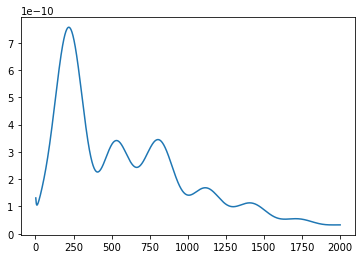

In [9]:
plt.plot(tt_ls, tt_dls, )

In [10]:
#calculate modal fraction for a power spectrum
def modal(dls):
    modal = dls/np.sum(dls)
    
    return modal
    
#calculate Jensen-Shannon divergence
def JSD(mod_Dl, dat_Dl):
    p, q = modal(mod_Dl), modal(dat_Dl)
    r = 1/2 * (p+q)
    
    return 1/2 * np.nansum(p*np.log(p/r)) + 1/2 * np.nansum(q*np.log(q/r))


In [11]:
####TO-DO: add truncation scheme

def initiate(params):
    
    directory = os.getcwd()
    fileName = os.path.join(directory,'planck/planck_tt_spectrum_2018.txt')
    l_data, Dl_data, Dl_data_err_lo, Dl_data_err_hi = np.loadtxt(fileName, unpack = True)
    
    ####TO-DO: add a_c to params (check axiCLASS)
    #log10_axion_ac = -3.7
    
    
    l_model, Cl_model, Dl_model = get_power(params)
    
    
    ##TO-DO: remove indexing when you add truncation scheme
    return Dl_model, Dl_data[:len(Dl_model)] #, l_max

In [15]:
import axiclass_mcmc as mcmc
import multiprocessing
from multiprocessing import Process
import time

start = time.time()

processlist = []

num_walkers = 10 #multiprocessing.cpu_count()


#doing this to reduce memory being hogged
og_ac = float(input_pars['log10_a_c'])
og_frac_ac = float(input_pars['fraction_fld_ac'])
pars = input_pars


#initiate and start all processes
for i in range(num_walkers):
    pars['log10_a_c'] = np.random.normal(og_ac, 0.5)
    pars['fraction_fld_ac'] = np.random.normal(og_frac_ac, 0.005)
    
    #open the parallel process on processor 
    process = Process(target=mcmc.MCMC_run, args=(pars,))
    processlist.append(process)
    process.start()
    
#join processes
for process in processlist:
    process.join()##

print('All done! Completed in ', time.time()-start, ' seconds.')

All done! Completed in  160.76998805999756  seconds.


In [14]:
import axiclass_mcmc as mcmc
import multiprocessing as mp
from multiprocessing import Pool
import time

start = time.time()

pool = mp.Pool(mp.cpu_count()+2)

num_walkers = 10

#doing this to reduce memory being hogged
og_ac = float(input_pars['log10_a_c'])
og_frac_ac = float(input_pars['fraction_fld_ac'])
pars = input_pars
#pars['n_axion'] = 2

for i in range(num_walkers):
    pars['log10_a_c'] = np.random.normal(og_ac, 0.5)
    pars['fraction_fld_ac'] = np.random.normal(og_frac_ac, 0.005)
    pool.apply_async(mcmc.MCMC_run, args=(pars,))


#pool.apply_async(mcmc.MCMC_run, args=(input_pars,))

pool.close()
pool.join()




print('All done! Completed in ', time.time()-start, ' seconds.')

All done! Completed in  153.3782880306244  seconds.


In [1]:
#Bubble sorting algortihm from https://realpython.com/sorting-algorithms-python/#the-bubble-sort-algorithm-in-python

def reorganize(log_ac_vals, JSD_vals):
    new_log_ac_vals, new_JSD_vals = log_ac_vals, JSD_vals
    n = len(log_ac_vals)
    
    for i in range(n):
        already_sorted = True
        
        for j in range(n-i-1):
            if new_log_ac_vals[j] > new_log_ac_vals[j+1]:
                new_log_ac_vals[j], new_log_ac_vals[j+1] = new_log_ac_vals[j+1], new_log_ac_vals[j]
                new_JSD_vals[j], new_JSD_vals[j+1] = new_JSD_vals[j+1], new_JSD_vals[j]
                
                already_sorted = False
                
        if already_sorted:
            break
            
    return new_log_ac_vals, new_JSD_vals
        

In [2]:
new_log_ac_n2, new_log_JSD_n2 = reorganize(log_ac_n2, JSD_n2)

plt.plot(new_log_ac_n2, new_log_JSD_n2 )
plt.scatter(log_ac_n2, JSD_n2)

NameError: name 'log_ac_n2' is not defined

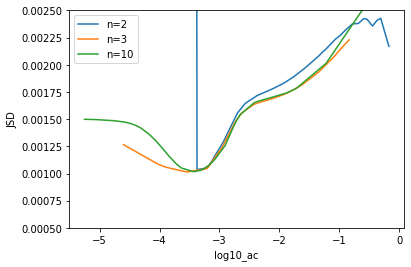

In [46]:
log_ac_n2, JSD_n2 = np.loadtxt('vary_ac_naxion=2.txt', unpack=True)
log_ac_n3, JSD_n3 = np.loadtxt('vary_ac_naxion=3.txt', unpack=True)
log_ac_n10, JSD_n10 = np.loadtxt('vary_ac_naxion=10.txt', unpack=True)

log_ac_n2, JSD_n2 = reorganize(log_ac_n2, JSD_n2)
log_ac_n3, JSD_n3 = reorganize(log_ac_n3, JSD_n3)
log_ac_n10, JSD_n10 = reorganize(log_ac_n10, JSD_n10)


plt.plot(log_ac_n2, JSD_n2, label='n=2')
plt.plot(log_ac_n3, JSD_n3, label='n=3')
plt.plot(log_ac_n10, JSD_n10, label='n=10')
plt.xlabel('log10_ac')
plt.ylabel('JSD')

plt.ylim([0.0005,0.0025])
#plt.xlim([-3.2,-2.9])
plt.legend()

plt.savefig('JSD_vs_log10_ac.pdf')

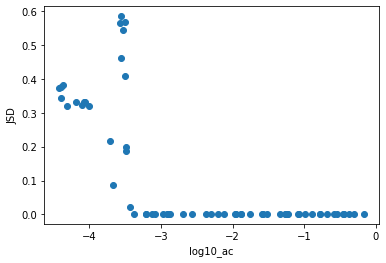

In [47]:
plt.scatter(log_ac_n2, JSD_n2)
plt.xlabel('log10_ac')
plt.ylabel('JSD')
plt.savefig('JSD_vs_log10_ac_n=2.pdf')

In [53]:
### to-do: make l_max set by truncation

def MCMC_run(params, numsteps, outFile): 
    
    burn_in_steps = 5
    
    #Dl_model, Dl_data, l_max = initiate(params)
    Dl_model, Dl_data = initiate(params)
    
    #starting chain
    JSD_current = JSD(Dl_model, Dl_data)
    p_current = -3.5 #whatever params you're varying in MCMC
    stdDevs = 0.5 #standard deviation for params
    
    #check if file to write to exists; create it if not
    #if not os.path.isfile(outFile):
    #    
    
    #with open(outFile, 'a') as fileObject:
    #    line = np.append(p_current, JSD_current)
    #    np.savetxt(fileObject,np.transpose(line),delimiter=',',newline = ' ')
    #    fileObject.write('\n')
        
    #tqdm progress bar     
    for t in tnrange(numsteps, desc='MCMC loop'):
        
        write_params_to_file = False
        
        #suggest a random value for params from a normal distrib centered on current values
        p_propose = norm(p_current, stdDevs).rvs()
        ##reset params array
        #fullParams = params
        ####TO-DO: write this fxn to use whatever variable param you want. hard-coded for now
        params['log10_axion_ac'] = p_propose
        
        l_propose, Cl_propose, Dl_propose = get_power(params)
        
        JSD_propose = JSD(Dl_propose, Dl_data)
        x = JSD_propose/JSD_current
        #JSD is smaller so take step
        #if x < 1:
        #    p_current = p_propose
        #    JSD_current = JSD_propose
        #    write_params_to_file = True
        ##Metropolis-Hastings - small chance of taking step even it doesn't have a lower JSD
        ##helps keep walker from getting stuck
        #####TO-DO: check lit to see if this acceptance is best way of doing this
        #elif np.random.rand() < (1/x)**2:
        #        p_current = p_propose
        #        JSD_current = JSD_propose
        #        print(p_current, JSD_current)
        #        write_params_to_file = True
        
        #Metropolis-Hastings acceptance criterion 
        #from https://github.com/AstroHackWeek/AstroHackWeek2015/blob/3e13d786ecb86fd4757c08ab63cfc08135933556/hacks/sklearn-CV-Bayes.py
        if x > np.random.uniform():   
            p_current = p_propose
            JSD_current = JSD_propose
            write_params_to_file = True
                
            if t > burn_in_steps:
                with open(outFile, 'a') as fileObject:
                    line = np.append(p_current, JSD_current)
                    np.savetxt(fileObject,np.transpose(line),delimiter=',',newline = ' ')
                    fileObject.write('\n')

        
    fileObject.close()

In [21]:
print(np.random.uniform(0, np.log(2)))

0.6901722765699982


In [ ]:
MCMC_run(input_pars, 200, 'log_ac_n=2')

<ipython-input-20-e5fcd79a6022>:25: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for t in tnrange(numsteps, desc='MCMC loop'):


MCMC loop:   0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-11-1a7cd2f50a25>:12: RuntimeWarning: invalid value encountered in log
  return 1/2 * np.nansum(p*np.log(p/r)) + 1/2 * np.nansum(q*np.log(q/r))


Text(0, 0.5, 'JSD')

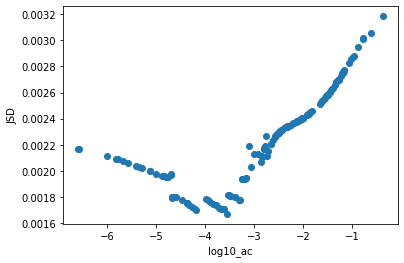

In [15]:
log_ac_vals, JSD_vals = np.loadtxt('test_log_ac.txt', unpack=True)


plt.scatter(log_ac_vals, JSD_vals)
plt.xlabel('log10_ac')
plt.ylabel('JSD')


In [49]:
print(JSD_vals)

[0.00250673 0.00250673 0.00265492 0.00241021 0.00235495 0.00238144
 0.00238144 0.00220684 0.00207495 0.00239069 0.00248927 0.00251639
 0.00251373 0.00236478 0.00221373 0.00247289 0.00246334 0.00231639
 0.00231639 0.00253739 0.00249517 0.00258713 0.0026008  0.00238375
 0.00249749 0.00241427 0.00241427 0.00241427 0.00257534 0.00246392
 0.00247675 0.00259281 0.0023203  0.00179725 0.00178724 0.00181224
 0.00177896 0.00178791 0.00178791 0.00180835 0.00180848 0.00172389
 0.00178149 0.00176192 0.00173148 0.00173148 0.00176504 0.00180256
 0.00171751 0.00173251 0.00196511 0.00179898 0.00197277 0.00179585
 0.00169837 0.00169837 0.00177406 0.00178519 0.00171099 0.00193737
 0.00180275 0.00180275 0.00176753 0.00168425 0.0017295  0.0017295
 0.00168179 0.00177055 0.00172115 0.00165112 0.0016851  0.00174435
 0.00171007 0.00174705 0.00179664 0.00177822 0.00178925 0.0016668
 0.00179743 0.00179743 0.00179743 0.00167758 0.00172462 0.00172462
 0.00171885 0.00176459 0.00178328 0.00179721 0.00168973 0.001751